In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from obspy.imaging.scripts.mopad import MomentTensor, BeachBall, USE2NED, NED2USE
from obspy.imaging.beachball import beachball


# Moment Tensor Radition Pattern

First version si calculating the radiation pattern for a "pure" DC, which is altred by an user adjustable gamma angle which indicates openening

the second version is using a arbitrary moment tensor, recalculating different inputs of MT and than recalulates the radiation pattern for the three different basic types (DC, CLVD, ISO).
'NED'	North, East, Down	Jost and Herrmann 1989
'USE'	Up, South, East	Global CMT Catalog, Larson et al. 2010
'XYZ'	East, North, Up	General formulation, Jost and Herrmann 1989
'RT'	Radial, Transverse, Tangential	psmeca (GMT), Wessel and Smith 1999
'NWU'	North, West, Up	Stein and Wysession 2003




In [17]:

def rpgen2(mtt,TKO,AZM,nargout=4):
    '''
    function [Gp, Gs, Gsh, Gsv] = rpgen(mtt, TKO, AZM)
    %RPGEN Calculate radiation pattern using arbitrary MT source model.
    %   rpgen2(mtt, TKO, AZM) calculates P-wave, S-wave,
    %   SH-wave and SV-wave radiation pattern using Moment Tensor. All input angles
    %   (strike, dip, rake of the fault, tensile angle gamma, takeoff angle
    %   TKO and azimuth from the source to the observation point AZM) should
    %   be in degrees. The takeoff angle is measure from bottom. The function
    %   returns matrices of the same size as input TKO and AZM matrices.
    %
    %   Input parameters:
    %     mtt: Moment Tensor (3x3) in NED representation
    %
    %     sigma:  Poisson's ratio.
    %     TKO:    matrix of takeoff angles for which to calculate the correspo-
    %             nding radiation pattern coefficients (degrees, the takeoff
    %             angles are measured from bottom).
    %     AZM:    matrix of corresponding azimuths (in degrees) for which the
    %             radiation pattern coefficients should be calculated.
    %
    %   Output parameters:
    %
    %     Gp, Gs, Gsh, Gsv - P-wave, S-wave, SH-wave, and SV-wave radiation
    %     pattern coefficients calculated for corresponding takeoff angles
    %     and azimuths specified in TKO and AZM matrices.
    %
    '''

    pi = np.pi
    cos = np.cos
    sin = np.sin

    m11 = mtt[0,0]
    m22 = mtt[1,1]
    m33 = mtt[2,2]
    m12 = mtt[0,1]
    m13 = mtt[0,2]
    m23 = mtt[1,2]

    #Gp = sin(TKO)**2*(cos(AZM)**2*m11+sin(AZM)**2*m22+sin(2*AZM)*m12)+cos(TKO)**2*m33+\
    #sin(2*TKO)*(cos(AZM)*m13+sin(AZM)*m23)
    Gp = (m11*cos(AZM)**2 + m22*sin(AZM)**2 +m12 * sin(2*AZM)) * sin(TKO)**2 +\
         (m13*cos(AZM))*2*sin(TKO)*cos(TKO) + m33 *cos(TKO)**2
    #Gsv = 0.5*sin(2*TKO)*(cos(AZM)**2*m11+sin(AZM)**2*m22-m33+sin(2*AZM)*m12)+\
    #cos(2*TKO)*(cos(AZM)*m13+sin(AZM)*m23)
    Gsv = m11*cos(AZM)**2+m22*sin(AZM)**2+m12*sin(2*TKO)+\
          m13*cos(AZM)+m23*sin(AZM)-m33
          
    #Gsh = sin(TKO)*(0.5*sin(2*AZM)*m22-0.5*sin(2*AZM)*m11+cos(2*AZM)*m12)+\
    #cos(TKO)*(cos(AZM)*m23-sin(AZM)*m13)
    Gsh = 0.5*(m22-m11)*sin(2*AZM)+m12*cos(2*AZM) + (m23*cos(AZM)-m13*sin(AZM))
    Gs = Gsv+Gsh
    R = m13*cos(TKO)*sin(AZM)-m23*cos(AZM)*cos(2*TKO)+\
        m11*cos(TKO)*sin(AZM)-m12*cos(AZM)*cos(2*TKO)-\
        m12*cos(TKO)*sin(AZM)+m22*cos(AZM)*cos(2*TKO)

    return Gp,Gs,Gsh,Gsv,R


In [4]:
def rpgen(strike,dip,rake,gamma,sigma,TKO,AZM,nargout=4):
    '''
    function [Gp, Gs, Gsh, Gsv] = rpgen(strike, dip, rake, gamma, sigma, TKO, AZM)
    %RPGEN Calculate radiation pattern using shear-tensile source model.
    %   rpgen(strike,dip,rake,gamma,sigma, TKO, AZM) calculates P-wave, S-wave,
    %   SH-wave and SV-wave radiation pattern using shear-tensile source model
    %   presented in [see references 1, 2, 3 for details]. All input angles
    %   (strike, dip, rake of the fault, tensile angle gamma, takeoff angle
    %   TKO and azimuth from the source to the observation point AZM) should
    %   be in degrees. The takeoff angle is measure from bottom. The function
    %   returns matrices of the same size as input TKO and AZM matrices.
    %
    %   Input parameters:
    %
    %     strike, dip, rake: fault plane parameters (degrees).
    %     gamma:  tensile angle in degrees (0 degrees for pure shear faulting,
    %             90 degrees for pure tensile opening).
    %     sigma:  Poisson's ratio.
    %     TKO:    matrix of takeoff angles for which to calculate the correspo-
    %             nding radiation pattern coefficients (degrees, the takeoff
    %             angles are measured from bottom).
    %     AZM:    matrix of corresponding azimuths (in degrees) for which the
    %             radiation pattern coefficients should be calculated.
    %
    %   Output parameters:
    %
    %     Gp, Gs, Gsh, Gsv - P-wave, S-wave, SH-wave, and SV-wave radiation
    %     pattern coefficients calculated for corresponding takeoff angles
    %     and azimuths specified in TKO and AZM matrices.
    %
    %   References:
    %
    %     [1] Kwiatek, G. and Y. Ben-Zion (2013). Assessment of P and S wave
    %         energy radiated from very small shear-tensile seismic events in
    %         a deep South African mine. J. Geophys. Res. 118, 3630-3641,
    %         doi: 10.1002/jgrb.50274
    %   Copyright 2012-2013 Grzegorz Kwiatek.
    %   $Revision: 1.3 $  $Date: 2013/09/15 $
    '''

    pi = np.pi
    cos = np.cos
    sin = np.sin

    strike = strike * pi/180;
    dip = dip * pi / 180;
    rake = rake * pi / 180;
    gamma = gamma * pi / 180;
    TKO = TKO * pi / 180;
    AZM = AZM * pi / 180;
    if nargout == 1:
        Gp = cos(TKO)*(cos(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake))\
        - cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike))\
        - sin(2.*dip)*sin(gamma)*sin(strike)) + sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake)\
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) \
        + sin(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike))\
        - sin(2.*dip)*cos(strike)*sin(gamma)) + cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + sin(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip)\
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)^2)))\
        - cos(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike))\
        - sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + cos(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip))\
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)))
    elif nargout == 2:
        Gp = cos(TKO)*(cos(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake))\
        - cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) + sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) + \
        sin(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2*dip)*cos(strike)*sin(gamma)) \
        + cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + sin(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) \
        - 2.*cos(strike)**2.*sin(dip)**2))) - cos(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike)) \
        - sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2*dip)*sin(2*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + cos(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 \
        + sin(2.*strike)*cos(rake)*sin(dip)) + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)))

        Gs = ((sin(AZM)*sin(TKO)*(cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + cos(TKO)*sin(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        - cos(TKO)*(sin(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake)) \
        + cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) - cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) \
        + cos(AZM)*sin(TKO)*(sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike)) \
        + cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) - cos(AZM)*cos(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 \
        + sin(2.*strike)*cos(rake)*sin(dip)) + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2))))**2 \
        + (cos(TKO)*(cos(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + sin(AZM)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike))) \
        - sin(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) - cos(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        + cos(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip)) \
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)) \
        + cos(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma))))**2)**(1./2)

    elif nargout == 3:
        Gp = cos(TKO)*(cos(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake))\
        - cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) + sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) + \
        sin(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2*dip)*cos(strike)*sin(gamma)) \
        + cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + sin(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) \
        - 2.*cos(strike)**2.*sin(dip)**2))) - cos(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike)) \
        - sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2*dip)*sin(2*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + cos(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 \
        + sin(2.*strike)*cos(rake)*sin(dip)) + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)))

        Gs = ((sin(AZM)*sin(TKO)*(cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + cos(TKO)*sin(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        - cos(TKO)*(sin(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake)) \
        + cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) - cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) \
        + cos(AZM)*sin(TKO)*(sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike)) \
        + cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) - cos(AZM)*cos(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 \
        + sin(2.*strike)*cos(rake)*sin(dip)) + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2))))**2 \
        + (cos(TKO)*(cos(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + sin(AZM)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike))) \
        - sin(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) - cos(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        + cos(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip)) \
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)) \
        + cos(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma))))**2)**(1./2)

        Gsh = cos(TKO)*(cos(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + sin(AZM)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike))) \
        - sin(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - cos(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) - sin(2.*dip)*cos(strike)**2.*sin(rake)) \
        - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        + cos(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip)) \
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)) \
        + cos(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)))
    elif nargout == 4:
        Gp = cos(TKO)*(cos(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake))\
        - cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) + sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) + \
        sin(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2*dip)*cos(strike)*sin(gamma)) \
        + cos(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + sin(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) \
        - 2.*cos(strike)**2.*sin(dip)**2))) - cos(AZM)*sin(TKO)*(cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike)) \
        - sin(AZM)*sin(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2*dip)*sin(2*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) + cos(AZM)*sin(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 \
        + sin(2.*strike)*cos(rake)*sin(dip)) + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)))

        Gs = ((sin(AZM)*sin(TKO)*(cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + cos(TKO)*sin(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        - cos(TKO)*(sin(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake)) \
        + cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) - cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) \
        + cos(AZM)*sin(TKO)*(sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike)) \
        + cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) - cos(AZM)*cos(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 \
        + sin(2.*strike)*cos(rake)*sin(dip)) + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2))))**2 \
        + (cos(TKO)*(cos(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + sin(AZM)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike))) \
        - sin(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)) - cos(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        + cos(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip)) \
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)) \
        + cos(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma))))**2)**(1./2)

        Gsh = cos(TKO)*(cos(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + sin(AZM)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) \
        + cos(dip)*cos(rake)*cos(strike)) - sin(2.*dip)*sin(gamma)*sin(strike))) \
        - sin(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - cos(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) - sin(2.*dip)*cos(strike)**2.*sin(rake)) \
        - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        + cos(AZM)*sin(TKO)*(sin(AZM)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip)) \
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)) \
        + cos(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) \
        - sin(2.*strike)*sin(dip)**2.*sin(gamma)))

        Gsv = sin(AZM)*sin(TKO)*(cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - sin(TKO)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) - cos(dip)*cos(rake)*sin(strike)) \
        - sin(2.*dip)*cos(strike)*sin(gamma)) + cos(TKO)*sin(AZM)*(cos(gamma)*(sin(2.*strike)*cos(rake)*sin(dip) \
        - sin(2.*dip)*cos(strike)**2.*sin(rake)) - sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*cos(strike)**2.*sin(dip)**2))) \
        - cos(TKO)*(sin(TKO)*(sin(gamma)*(2.*cos(dip)**2 - (2.*sigma)/(2.*sigma - 1)) + sin(2.*dip)*cos(gamma)*sin(rake)) \
        + cos(AZM)*cos(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) - cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*dip)*cos(strike)*sin(rake) \
        - cos(dip)*cos(rake)*sin(strike)) - sin(2.*dip)*cos(strike)*sin(gamma))) \
        + cos(AZM)*sin(TKO)*(sin(TKO)*(cos(gamma)*(cos(2.*dip)*sin(rake)*sin(strike) + cos(dip)*cos(rake)*cos(strike)) \
        - sin(2.*dip)*sin(gamma)*sin(strike)) + cos(TKO)*sin(AZM)*(cos(gamma)*(cos(2.*strike)*cos(rake)*sin(dip) \
        + (sin(2.*dip)*sin(2.*strike)*sin(rake))/2) - sin(2.*strike)*sin(dip)**2.*sin(gamma)) \
        - cos(AZM)*cos(TKO)*(cos(gamma)*(sin(2.*dip)*sin(rake)*sin(strike)**2 + sin(2.*strike)*cos(rake)*sin(dip)) \
        + sin(gamma)*((2.*sigma)/(2.*sigma - 1) - 2.*sin(dip)**2.*sin(strike)**2)))

    return Gp,Gs,Gsh,Gsv

        

In [7]:
#Some settings 

pi = np.pi
AZIMUTH = np.arange(0,364,4)*np.pi/180.
TAKEOFF = np.arange(0,182,2)*np.pi/180.
AZIMUTH,TAKEOFF = np.meshgrid(AZIMUTH,TAKEOFF)

colormap = cm.ScalarMappable( cmap=plt.get_cmap("viridis"))
colormap2 = cm.ScalarMappable( cmap=plt.get_cmap("hot"))
from matplotlib import cm


<IPython.core.display.Javascript object>


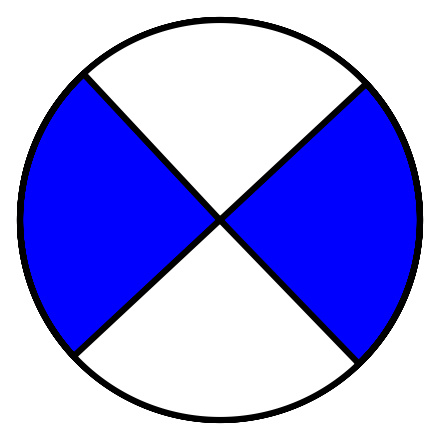

In [14]:
strike = 47;
dip = 90;
rake = 0;
sigma = 0.25;
gamma = 0;
fig = beachball([strike,dip,rake])

<IPython.core.display.Javascript object>


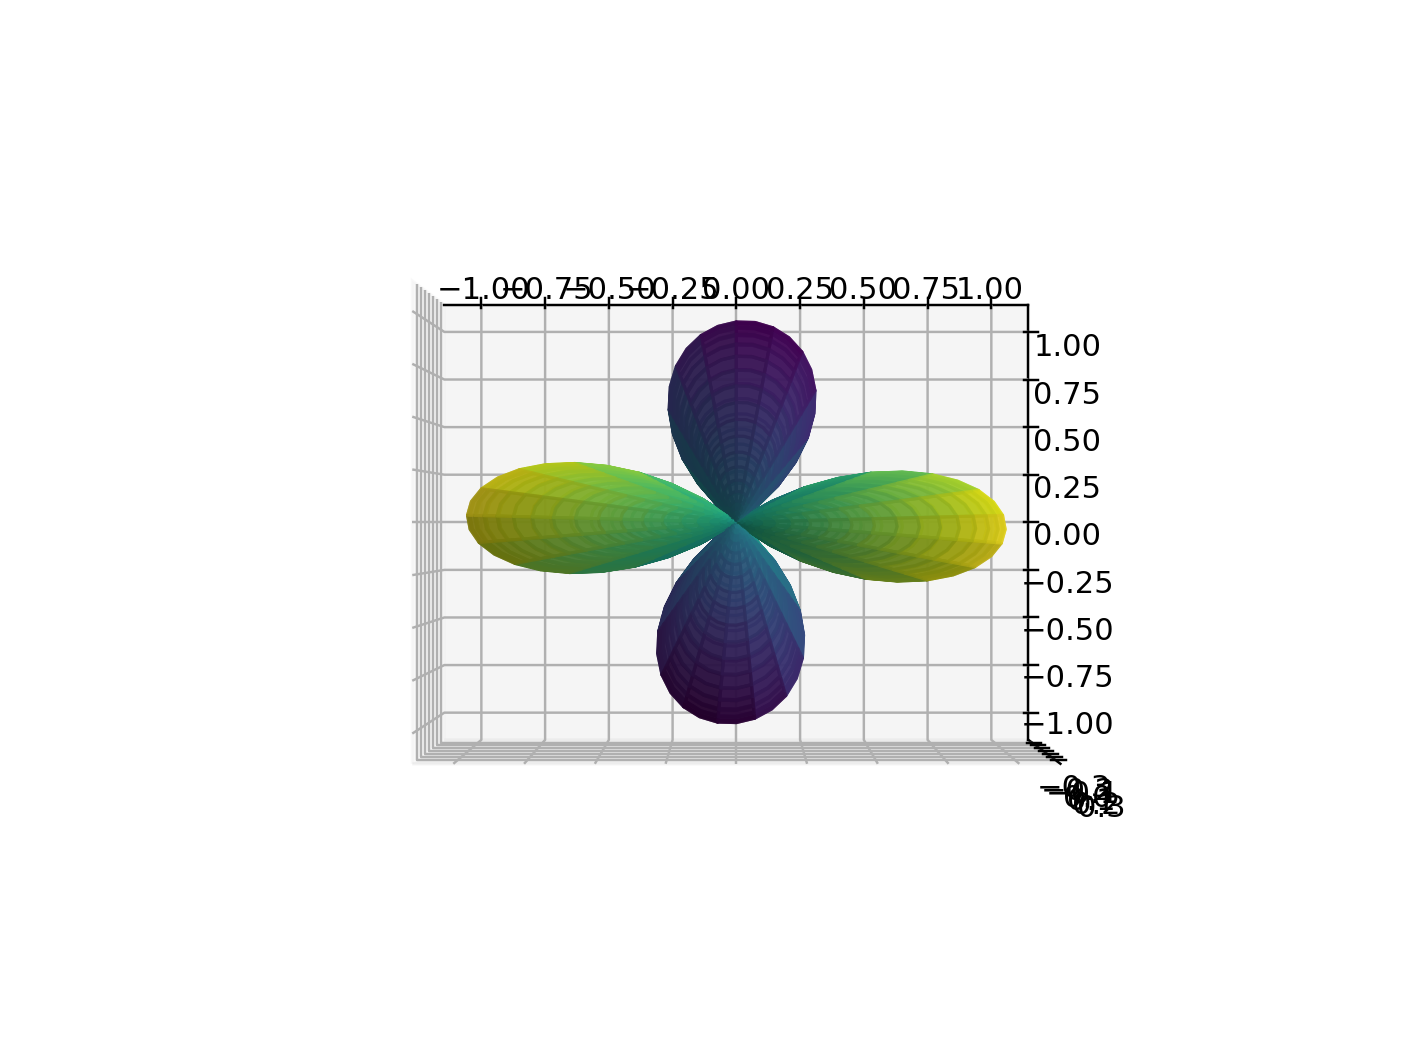

<IPython.core.display.Javascript object>


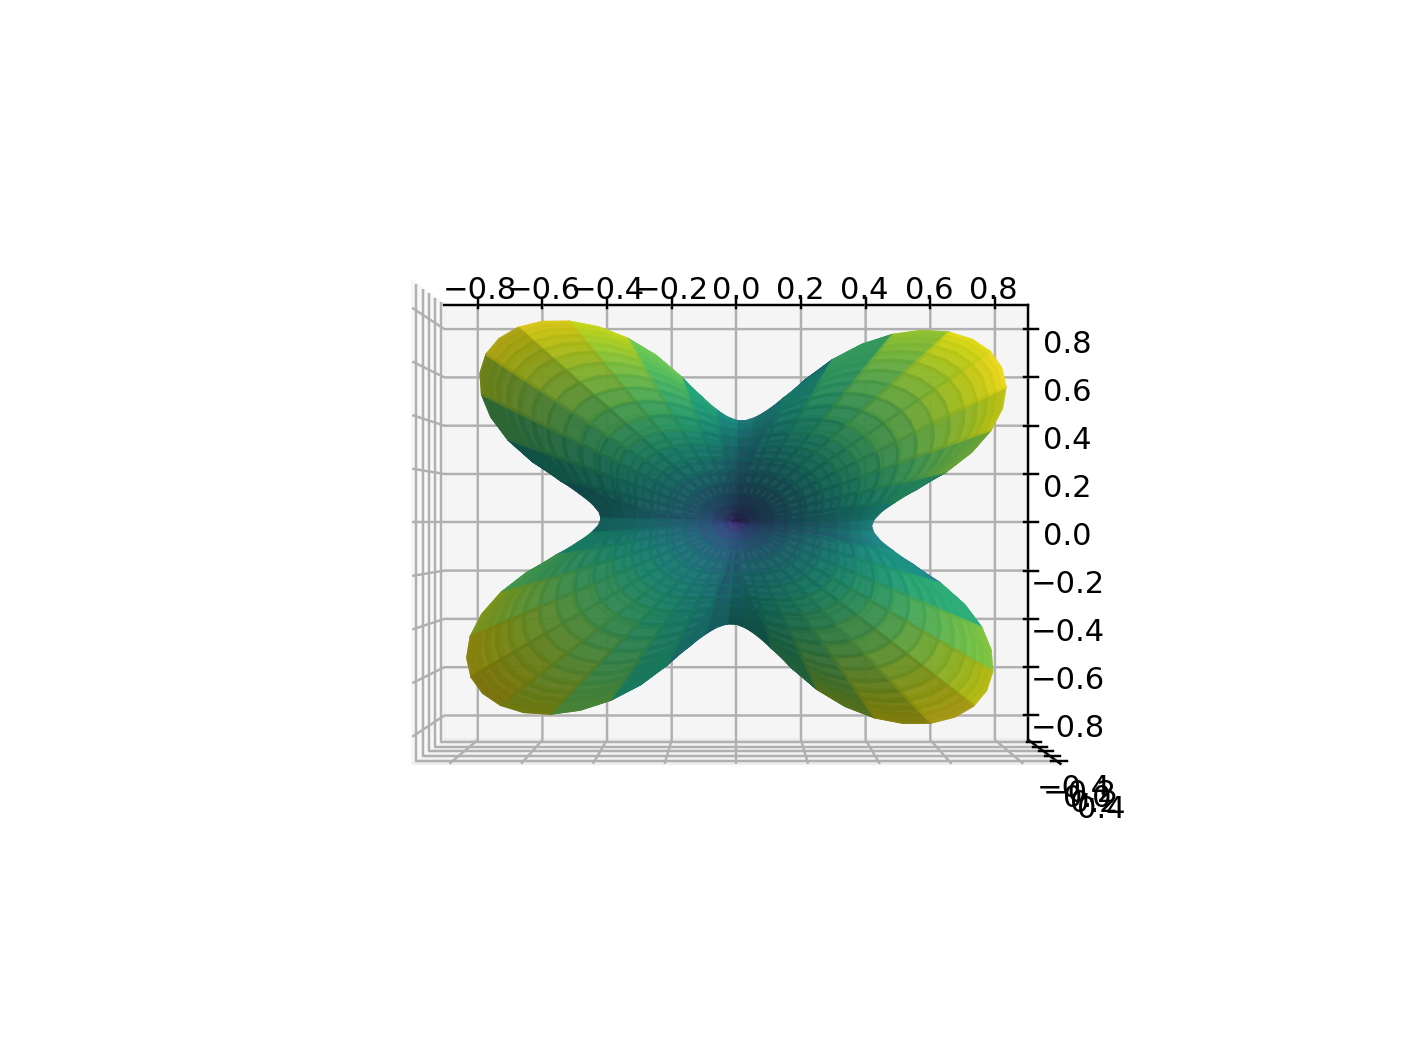

<IPython.core.display.Javascript object>


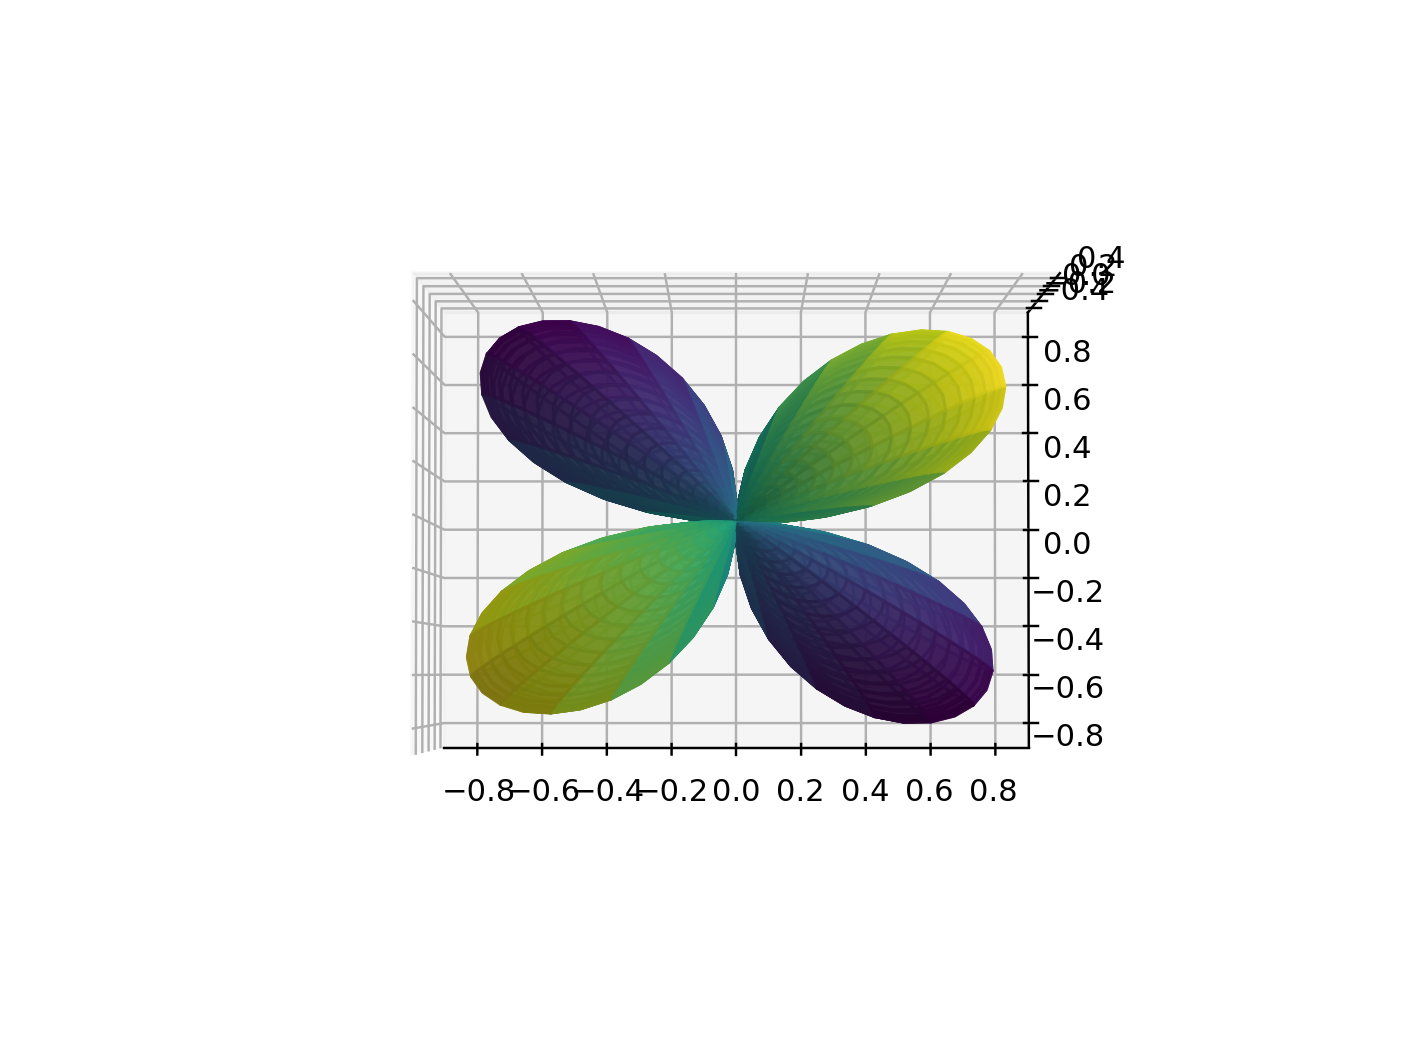

<IPython.core.display.Javascript object>


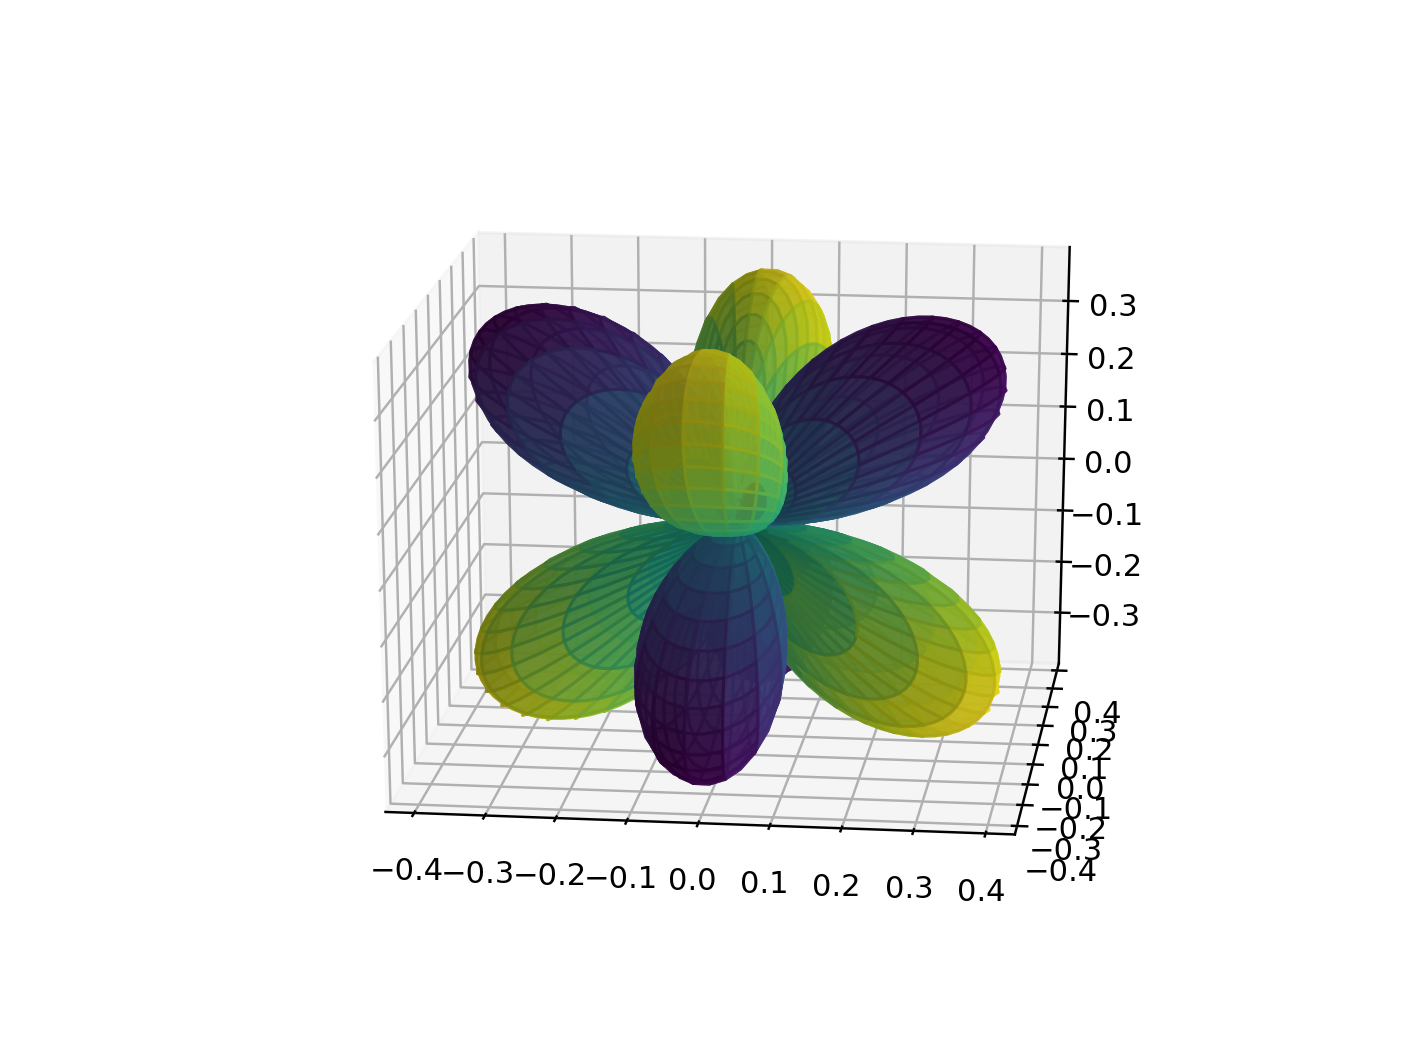

In [23]:
point = np.array([0,0,0])
normal = np.array([np.cos((90+strike)*pi/180)*np.sin((90-dip)*pi/180),np.sin((90+strike)*pi/180)*np.sin((90-dip)*pi/180),-np.cos((90-dip)*pi/180)])
d = point.dot(normal)
x = np.arange(-1,1,0.1)
y = np.arange(-1,1,0.1)
x,y=np.meshgrid(x,y)
# calculate corresponding z
z = (-normal[0] * x - normal[1] * y - d) * 1. /normal[2]

GP, GS, GSH, GSV = rpgen(strike,dip,rake,gamma,sigma, TAKEOFF*180/pi, AZIMUTH*180/pi);

radi = [GP,GS,GSH,GSV]
for ty in radi:
    scale = abs(ty);
    col = ty
    YP = scale*np.cos(AZIMUTH) * np.sin(TAKEOFF);
    XP = scale*np.sin(AZIMUTH) * np.sin(TAKEOFF);
    ZP = scale*-np.cos(TAKEOFF);

    colormap = cm.ScalarMappable( cmap=plt.get_cmap("viridis"))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(XP,YP,ZP,facecolors=colormap.to_rgba(col),alpha=0.8)
    #ax.set_frame_on(False)
    #ax._axis3don = False
    ax.view_init(elev=90., azim=-90)
    #plt.savefig("UH_radiation.png",dpi=300,transparent=True)

    #ax.plot_surface(x, y, z, color="red",alpha=0.2)
    plt.show()
                                                                                                     

<IPython.core.display.Javascript object>


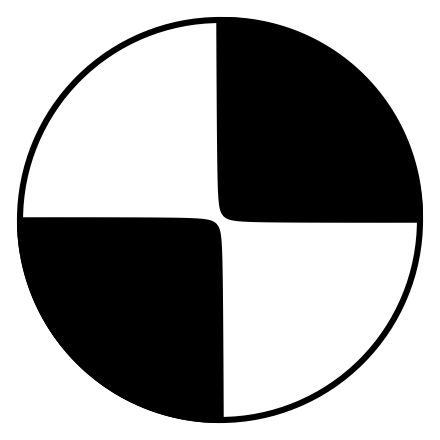

[(0.0, 0.14323825514505925, -90.0), (180.0, 89.856761744861473, -90.0)]
DC  98
CLVD  1
ISO  1


In [13]:

#mt_sw4=np.array([17.82e6,17.472e6,13.062e6,0.3e6,0.966e6,1.67e6])
mt_sw4=np.array([4,2,2,200,0,0])
mt_neic = NED2USE(mt_sw4)
fig = beachball(mt_neic,facecolor="black")
fig.savefig("mopad_stromb_incline.png",dpi=300,transparent=True)
#mt_neic=np.array([-2,1,1,0,0,0])
#Moment Tensor in NED
mt = USE2NED(mt_neic)
mt = MomentTensor(mt_neic)
print(mt.get_fps())
print("DC ",mt.get_DC_percentage())
print("CLVD ",mt.get_CLVD_percentage())
print("ISO ",mt.get_iso_percentage())

<IPython.core.display.Javascript object>


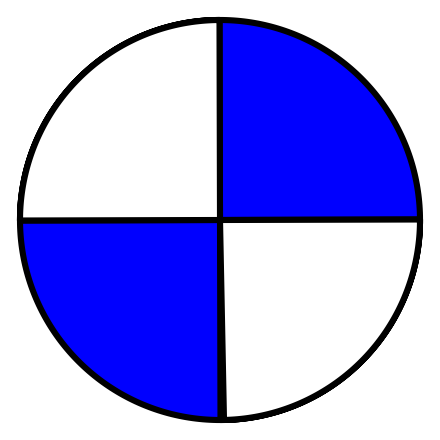

[[   0.            0.            0.        ]
 [   0.            0.99500006 -199.0000125 ]
 [   0.         -199.0000125    -0.99500006]]


<IPython.core.display.Javascript object>


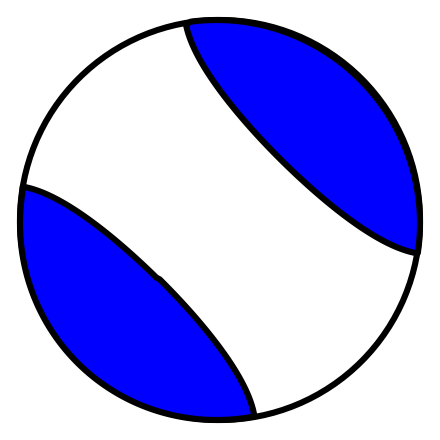

[[-0.66666667  0.          0.        ]
 [ 0.          0.33833327 -0.9999875 ]
 [ 0.         -0.9999875   0.3283334 ]]


<IPython.core.display.Javascript object>


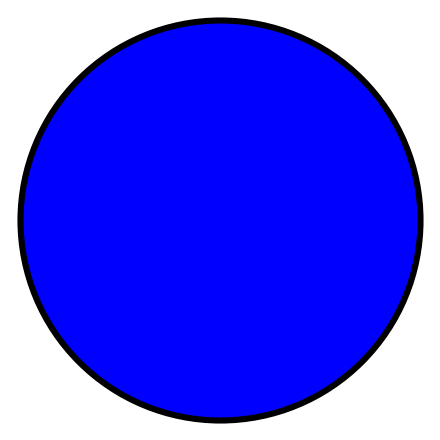

[[ 2.66666667  0.          0.        ]
 [ 0.          2.66666667  0.        ]
 [ 0.          0.          2.66666667]]


In [18]:
#Plot the beachball for each of the main contributions
#DC
mdc = mt.get_DC()
beachball([mdc[0,0],mdc[1,1],mdc[2,2],mdc[0,1],mdc[0,2],mdc[1,2]])
print(mdc)
GP1, GS1, GSH1, GSV1,R1 = rpgen2(mdc, TAKEOFF, AZIMUTH);
#CLVD
mclvd = mt.get_CLVD()
beachball([mclvd[0,0],mclvd[1,1],mclvd[2,2],mclvd[0,1],mclvd[0,2],mclvd[1,2]])
print(mclvd)
GP2, GS2, GSH2, GSV2,R2 = rpgen2(mclvd, TAKEOFF, AZIMUTH);
#Isotropic
miso = mt.get_iso()
beachball([miso[0,0],miso[1,1],miso[2,2],miso[0,1],miso[0,2],miso[1,2]])
print(miso)
GP3, GS3, GSH3, GSV3,R3 = rpgen2(miso, TAKEOFF, AZIMUTH);

In [19]:
#Combine all coomponents to form the representative radiation

GP = GP1 #+ GP2 + GP3 #P
GS = GS1 #+ GS2 + GS3 #all S
GSV = GSV1 #+ GSV2 + GSV3 #SV only
GSH = GSH1 #+ GSH2 + GSH3 #SH only

radi = [GP,GS,GSV,GSH]

<IPython.core.display.Javascript object>


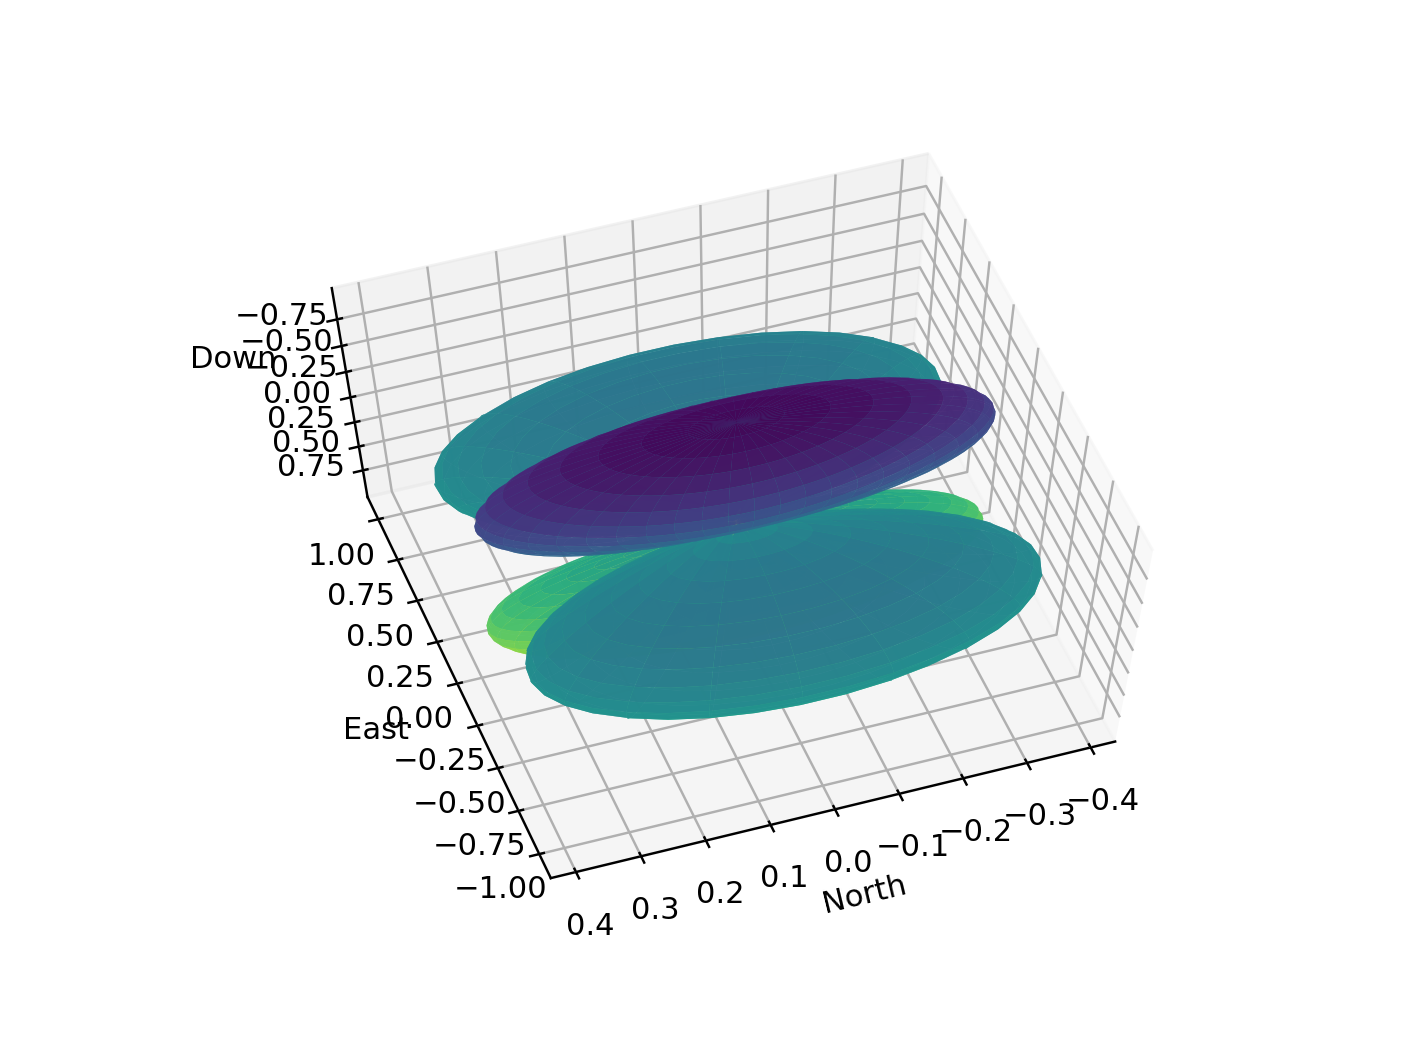

<IPython.core.display.Javascript object>


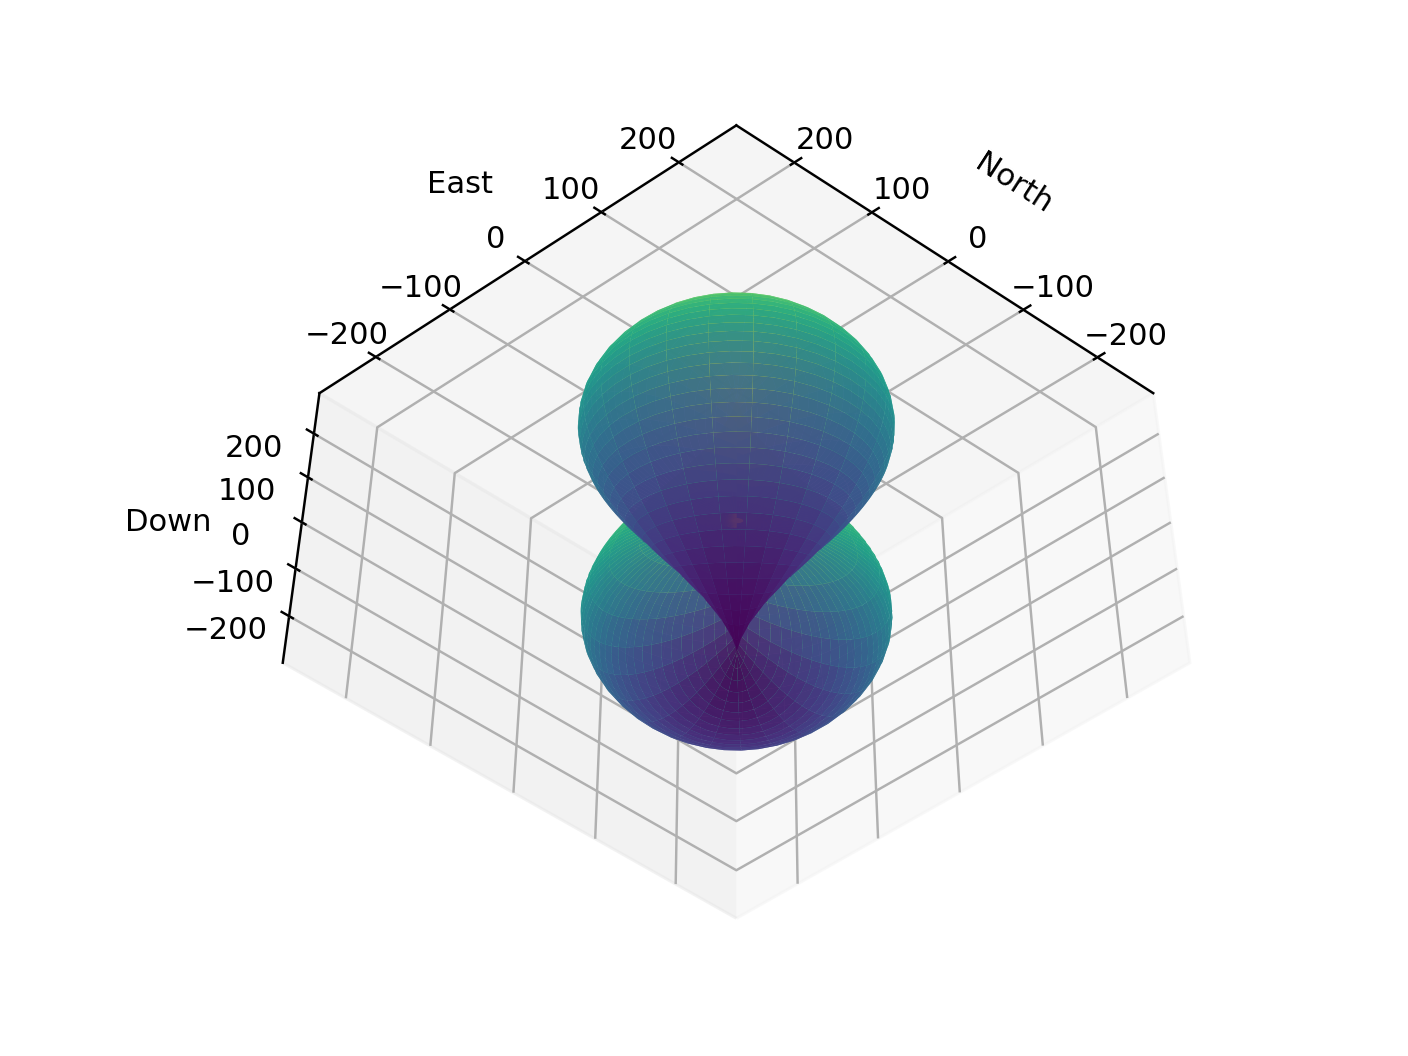

<IPython.core.display.Javascript object>


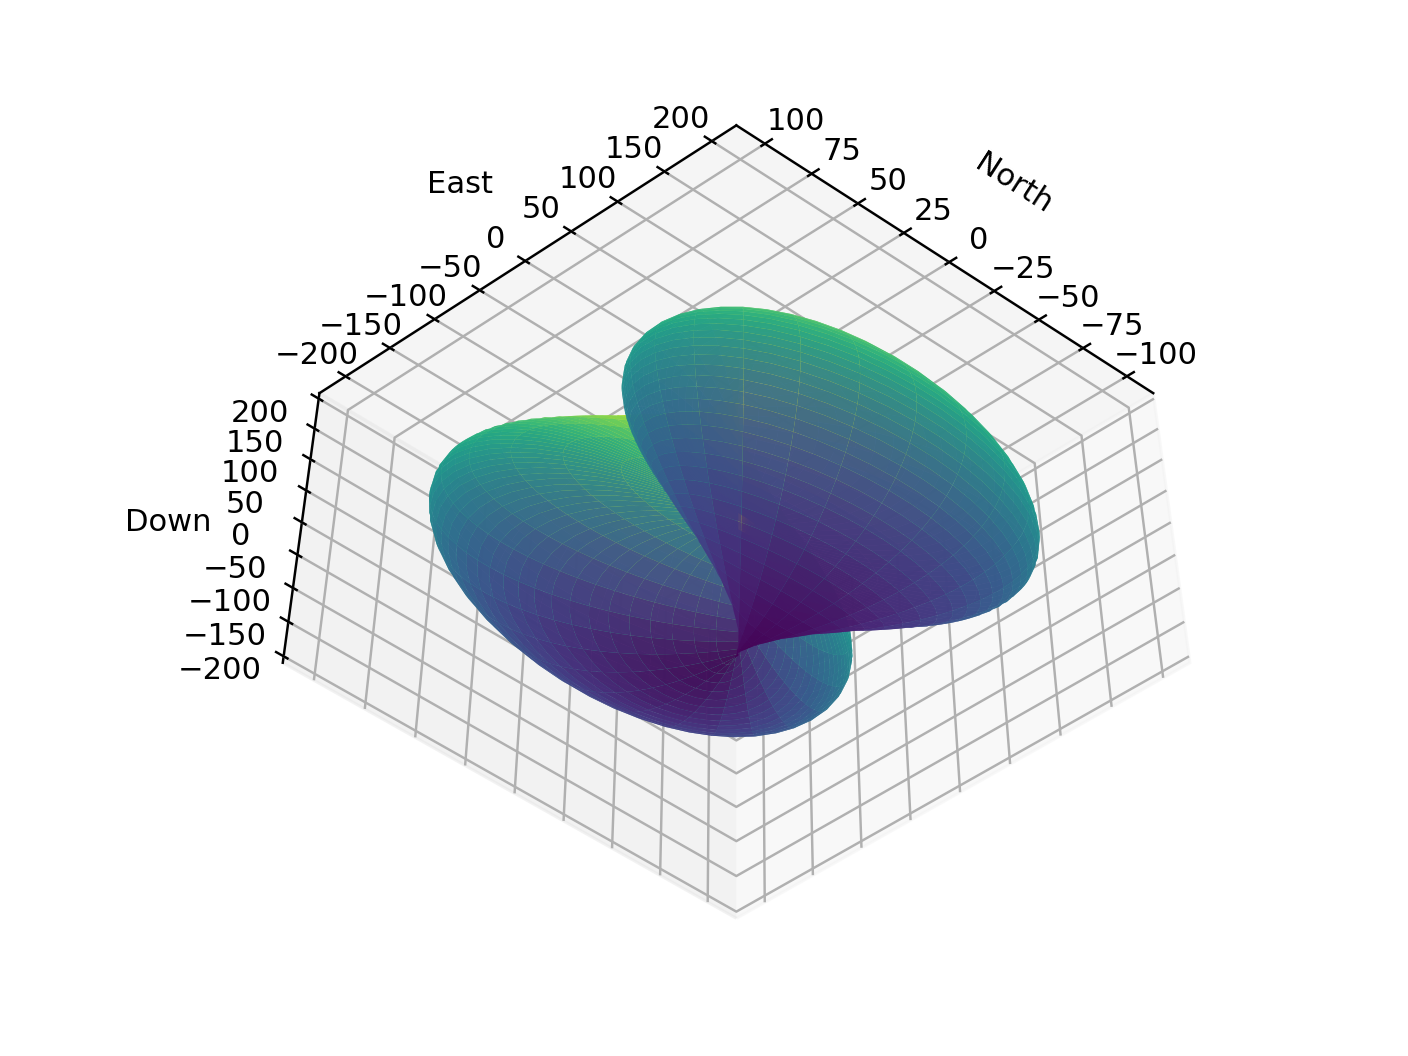

<IPython.core.display.Javascript object>


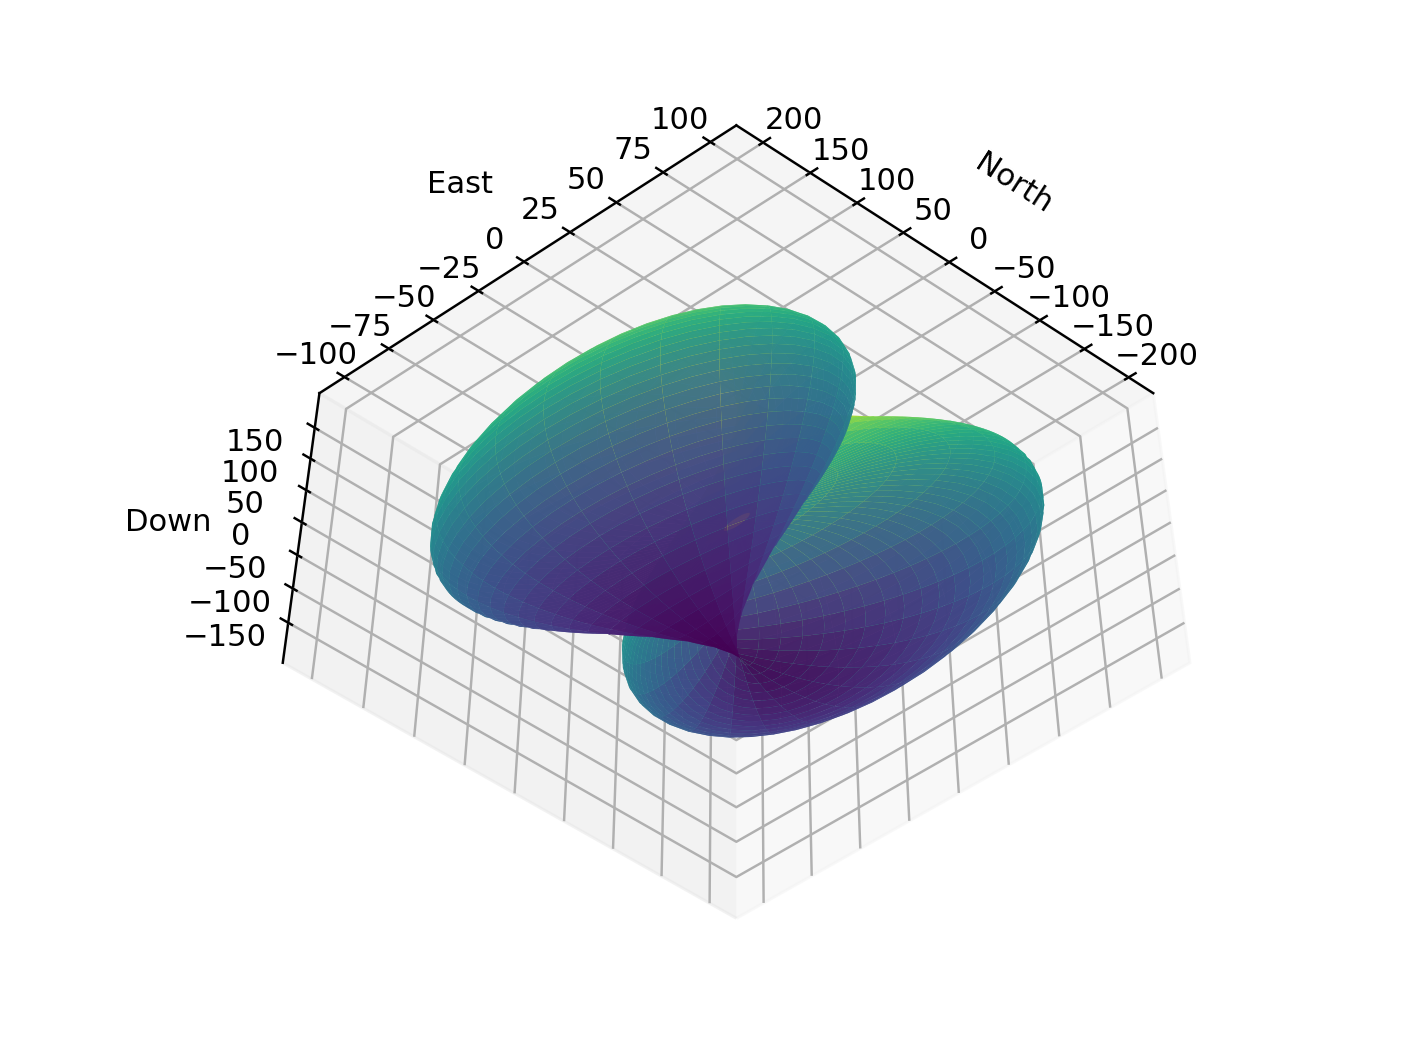

In [20]:
from matplotlib import cm

# Plot it...
what = ["P-Radiation","S-Radiation","SV-Radiation","SH-Radiation"]
for i,ty in enumerate (radi):
    fmt = what[i]
    scale = abs(ty);
    col = ty
#Plotting the surface - not sure about the Z coordinate though
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    XP = scale*np.cos(AZIMUTH) * np.sin(TAKEOFF);
    YP = scale*np.sin(AZIMUTH) * np.sin(TAKEOFF);
    ZP = scale*-np.cos(TAKEOFF);
    ax.plot_surface(XP,YP,ZP,cmap=cm.viridis,alpha=0.9)

#plotting the station in it
    AZIM_STA = 305*pi/180
    TKO_STA = 70*pi/180
    XX = np.cos(AZIM_STA) * np.sin(TKO_STA)*np.max(abs(col))
    YY = np.sin(AZIM_STA) * np.sin(TKO_STA)*np.max(abs(col))
    ZZ = np.cos(TKO_STA)*np.max(abs(col));

#    ax.scatter(XX,YY,ZZ,c="black",marker="^",s=20)

    ax.set_xlabel("North")
    ax.set_ylabel("East")
    ax.set_zlabel("Down")

#    ax.plot_surface(x, y, z, color="red",alpha=0.2)
    ax.view_init(elev=-54,azim=45)
    #plt.savefig('%s.png'%(fmt), format="png", dpi=300,transparent=True)
    plt.show()
                           